# TP1 : Algorithme EM et modèle de mélange gaussien

## Introduction à l'estimation statistique - G3 SDIA

L'objectif de ce TP est d'implémenter l'algorithme EM pour estimer par maximum de vraisemblance les paramètres d'un modèle de mélange gaussien.

On utilisera le dataset *Old Faithful*, qui décrit 272 éruptions du geyser appelé Old Faithful du parc national de Yellowstone aux États-Unis. Chaque observation est constituée de 2 variables : le temps d'attente avant l'éruption (en minutes) et la durée de l'éruption (en minutes).

### Instructions

1. Renommer votre notebook sous la forme `tp1_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 15 Octobre 2023, 23h59.

In [1]:
# Import necessary libraries
import numpy as np
import scipy.stats as ss
import seaborn
from matplotlib import pyplot as plt

**Q1**. Charger le dataset, normaliser puis visualiser les données. Commenter.

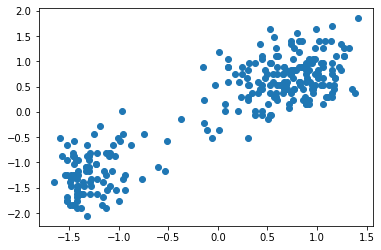

In [2]:
# Load the "Old Faithful" dataset from the Seaborn library
df = seaborn.load_dataset('geyser')
X = df[['duration', 'waiting']].values
N, D = X. shape

# Standardize data to avoid numerical instabilities
X_normalized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
# Show data
plt.scatter(X_normalized[:, 0], X_normalized[:, 1])
plt.show()

On voit clairement que les données sont réparties en deux groupes. On peut donc supposer qu'elles suivent une loi normale. On va donc essayer de les modéliser avec un mélange de deux gaussiennes.

**Q2**. On note $\mathbf{x}_1,...,\mathbf{x}_n$ les données. On souhaite les modéliser par un modèle de mélange gaussien à $K$ composantes.

Écrire une fonction permettant de calculer la log-vraisemblance :
$$ \log \mathcal{L}(\theta;\mathbf{x}_1,...,\mathbf{x}_n) = \sum_{i=1}^n \log \left( \sum_{k=1}^K \pi_k \frac{1}{2 \pi \text{det}(\boldsymbol{\Sigma}_k)^{1/2}} \exp \left( \frac{1}{2} (\mathbf{x}_i - \boldsymbol{\mu}_k)^{\top} \boldsymbol{\Sigma}_k^{-1} (\mathbf{x}_i - \boldsymbol{\mu}_k) \right) \right), $$
avec $\theta = \{ \boldsymbol{\mu_1}, ..., \boldsymbol{\mu_k}, \boldsymbol{\Sigma}_1, ..., \boldsymbol{\Sigma}_k, \pi_1, ..., \pi_k \}$.

On pourra utiliser la fonction $\texttt{multivariate} \_ \texttt{normal.pdf}$ de la librairie scipy.stats.

In [3]:
X.shape

(272, 2)

In [4]:
def log_likelihood(X,theta): # Fill in the appropriate arguments
    
    log_likelihood = 0
    K = int(len(theta)/3)
    for i in range(len(X)):
        log_likelihood += np.log(sum([theta[2*K+k]*ss.multivariate_normal.pdf(X[i], theta[k],theta[K+k]) for k in range(K)]))
    return(log_likelihood)
     
     
# Test

premier_vect = np.array([[1,2],[3,4],[5,6],[7,1],[9,1],[11,12],[1,0],[15,0],[17,18],[10,20]])
deuixème_vect = np.array([[[1,0],[0,1]]]*10)
troisième_vect = np.array([0,2,1,1,1,0,7,0,9,1])

theta =[]
for i in range(10):
    theta.append(premier_vect[i])
for i in range(10):
    theta.append(deuixème_vect[i])
for i in range(10):
    theta.append(troisième_vect[i])
    
 
log_likelihood(X_normalized, theta)

-378.46310113938546

**Q3**. Écrire une fonction qui implémente l'algorithme EM dans ce modèle, prenant pour arguments les données, le nombre de composantes $K$, et le nombre d'itérations de l'algorithme $N_{\text{iter}}$. Cette fonction retournera un tableau de taille $N_{\text{iter}} + 1$ contenant l'évolution des valeurs de la log-vraisemblance, ainsi que les valeurs finales des paramètres.

Initialisation des paramètres :
- Pour les moyennes, les $K$ premières observations du dataset ;
- Pour les matrices de covariances, la matrice identité ;
- $\pi_k = 1/K$.

In [6]:
def EM_algorithm_v1(X, K, Niter):
    N, D = X. shape
    
    # Initialize parameters
    
    theta = []
    for i in range(K):
        theta.append(X[i])
    for i in range(K):
        theta.append(np.eye(D))
    for i in range(K):
        theta.append(1/K)
 
    log_vraisemblance = [log_likelihood(X,theta)]
    for i in range(0,Niter):

        # E-STEP
        r = [[theta[2*K+k]*ss.multivariate_normal.pdf(X[n], theta[k],theta[K+k])/sum([theta[2*K+k]*ss.multivariate_normal.pdf(X[n], theta[k],theta[K+k]) for k in range(K)]) for k in range(K)] for n in range(N)]
        # M-STEP
        theta = []
        for k in range(K):
            theta.append(sum([r[n][k]*X[n] for n in range(N)])/sum([r[n][k] for n in range(N)]))
        for k in range(K):
            theta.append((sum([r[n][k]*X[n].reshape(D,1).dot(X[n].reshape(D,1).T) for n in range(N)])/sum([r[n][k] for n in range(N)]))- theta[k].reshape(K,1).dot(theta[k].reshape(D,1).T))
        for k in range(K):
            theta.append(sum([r[n][k] for n in range(N)])/N)

        log_vraisemblance.append(log_likelihood(X,theta))
        
    return theta, log_vraisemblance



**Q4**. Faire tourner l'algorithme avec $K = 2$ et $N_{\text{iter}} = 50$.

Afficher l'évolution de la log-vraisemblance en fonction des itérations. Commenter.

Sur une même figure, afficher le dataset et représenter les estimations des deux lois normales du mélange à l'aide d'un *contour plot*. On pourra utiliser la fonction $\texttt{plt.contour}$.

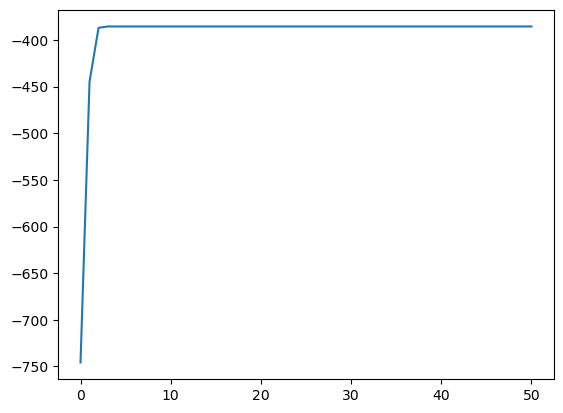

In [7]:
K = 2
Niter = 50
theta, log_vraisemblance = EM_algorithm_v1(X_normalized, K, Niter)
plt.plot(log_vraisemblance)

On voit bien que l'algorithme EM maxmiser la vraisemblance du modèle.

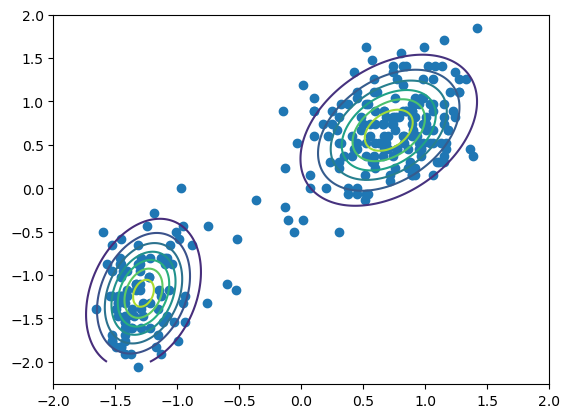

In [8]:
x = np.linspace(-2, 2, N)
y = np.linspace(-2, 2, N)
X_, Y_ = np.meshgrid(x, y)
grid = np.dstack((X_, Y_))
plt.scatter(X_normalized[:, 0], X_normalized[:, 1])
plt.contour(X_, Y_ ,theta[4]*ss.multivariate_normal.pdf(grid, theta[0],theta[2]))
plt.contour(X_, Y_ , theta[5]*ss.multivariate_normal.pdf(grid, theta[1],theta[3]))

**Q5**. On souhaite maintenant étudier l'influence de l'initialisation sur les résultats. Modifier la fonction implémentant l'algorithme EM en y rajoutant un argument pour la graine aléatoire. Les paramètres seront maintenant initialisés de la manière suivante :
- $\boldsymbol{\mu}_k \sim \mathcal{N}(\mathbf{0},\mathbf{I}_2)$ ;
- $[\pi_1, ..., \pi_K]^{\top} \sim \text{Dirichlet}([1, ..., 1]^{\top})$ ;
- On gardera l'initialisation des matrices de covariance à la matrice identité.

In [10]:
def EM_algorithm_v2(X, K, Niter, seed):
    N, D = X. shape
    
    # Initialize parameters
    np.random.seed(seed)

    theta = []
    for i in range(K):
        theta.append(np.random.rand(D))
    for i in range(K):
        theta.append(np.eye(D))

    t = np.random.dirichlet(np.ones(K))
    for i in range(K):
        theta.append(t[i])

    log_vraisemblance = [log_likelihood(X,theta)]
    for i in range(0,Niter):

        # E-STEP
        r = [[theta[2*K+k]*ss.multivariate_normal.pdf(X[n], theta[k],theta[K+k])/sum([theta[2*K+k]*ss.multivariate_normal.pdf(X[n], theta[k],theta[K+k]) for k in range(K)]) for k in range(K)] for n in range(N)]
        # M-STEP
        theta = []
        for k in range(K):
            theta.append(sum([r[n][k]*X[n] for n in range(N)])/sum([r[n][k] for n in range(N)]))
        for k in range(K):
            theta.append((sum([r[n][k]*X[n].reshape(2,1).dot(X[n].reshape(2,1).T) for n in range(N)])/sum([r[n][k] for n in range(N)]))- theta[k].reshape(2,1).dot(theta[k].reshape(2,1).T))
        for k in range(K):
            theta.append(sum([r[n][k] for n in range(N)])/N)

        log_vraisemblance.append(log_likelihood(X,theta))
        
    return theta, log_vraisemblance



**Q6**. On choisit maintenant $K=3$. Représenter l'évolution de la log-vraisemblance pour 10 graines aléatoires différentes. Commenter.

Afficher deux cas où la solution retournée par l'algorithme EM est visuellement différente. Commenter.

Quelle estimation de paramètres doit-on choisir ?

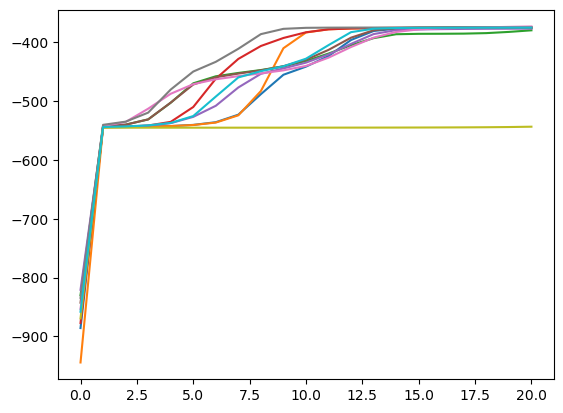

In [11]:
K = 3
Niter = 20
for i in range(10):
    seed = np.random.randint(1000)
    theta, log_vraisemblance = EM_algorithm_v2(X_normalized, K, Niter, seed)
    plt.plot(log_vraisemblance)
    

On remarque que la convergence de l'algorithme EM ne dépend pas des initialisations, pourtant la limite finale l'est .On voit sur la figure que certaines points d'initialisation améliore la vitesse de convergence . 

**Q7**. On cherche maintenant à choisir la valeur optimale de $K$. Pour cela, on aimerait pouvoir comparer la vraisemblance des modèles obtenus avec différentes valeurs de $K$.

Cela peut se faire au travers d'un critère de sélection de modèle. Dans ce TP, nous étudierons le critère dit BIC :
$$ \text{BIC}(m) = k(m) \log(n) - 2 \log \mathcal{L}(m),$$
où $m$ est un modèle (ici donné par une valeur de $K$), $k_m$ est le nombre de paramètres libres dans le modèle, $n$ le nombre d'échantillons, et $\mathcal{L}_m$ le maximum de la fonction de vraisemblance du modèle $m$. On sélectionne le modèle avec le plus faible BIC.

Montrer que $$k(m) = \frac{K}{2} (D+1)(D+2) - 1.$$

Comparer les valeurs de $K$ allant de 1 à 6. Quel est le modèle optimal d'après le critère BIC ?

Le nombre des paramères libres de modèle est le nombre des paramètres libre de theta. On a $K$ moyennes, $K$ matrices de covariances et $K$ pi. Donc on a $DK(K+1)/2$ paramètres libres pour les matrices de covariances (car ces des matrices symétriques). On a $KD$ paramètres libres pour les moyennes. On a $K-1$ paramètres libres pour les pi car la somme des pi est égale à 1. Donc on a $K(K+1)/2 + K(D+1) + K-1 = K/2(D+1)(D+2) - 1$ paramètres libres pour le modèle m.

Text(0.5, 1.0, 'BIC en fonction de K')

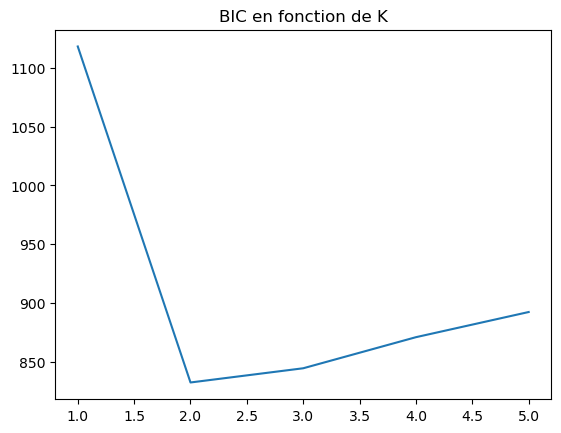

In [167]:
BIC =[]
Niter = 20
seed = 3
for k in range(1,6):
    theta, log_vraisemblance = EM_algorithm_v2(X_normalized, k, Niter, seed)
    km = k/2*((D+1)*(D+2))-1
    BIC.append(-2*log_likelihood(X_normalized,theta)+km*np.log(N))
    
plt.plot(range(1,6),BIC)
plt.title("BIC en fonction de K")

On remarque que le modèle optimal est celui avec $K=2$.

**Question bonus**. Expliquer comment l'algorithme EM peut-être utilisé pour du clustering.

 
Pour faire le clustring on peut calculer, pour chauqe point de données, les probabilités a posteriori (probabilités d'appartenir à chaque cluster) en utilisant les paramètres du modèle : 
$$ \gamma_{ik} = \frac{\pi_k \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)} $$
Attribuez chaque point de données au cluster pour lequel il a la plus grande probabilité a posteriori. En d'autres termes, assignez le point au cluster qui maximise la probabilité d'appartenance. 

In [178]:
#test
K = 2
Niter = 50
seed = 3
theta, log_vraisemblance = EM_algorithm_v2(X_normalized, K, Niter, seed)

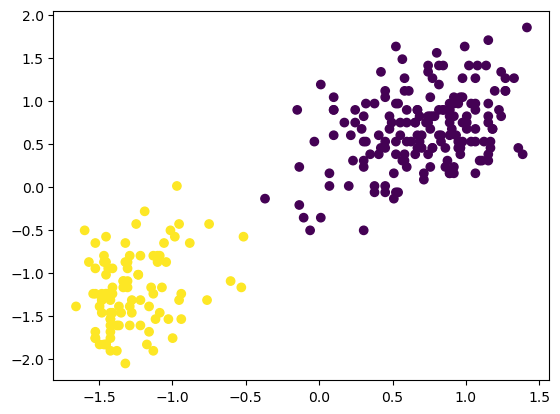

In [179]:
prob_class = np.array([theta[2*K+k]*ss.multivariate_normal.pdf(X_normalized, theta[k],theta[K+k]) for k in range(K)])
prob_class_norm = prob_class/np.sum(prob_class, axis=0)
plt.scatter(X_normalized[:, 0], X_normalized[:, 1], c=np.argmax(prob_class, axis=0))